In [ ]:
pip install -r requirements.txt

In [26]:
# Import Needed Packages
import os
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tensorflow import keras
import matplotlib.pyplot as plt
from shutil import copyfile
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [ ]:
'''
create the structure of dataset like this:
training
   |______normal
   |______abnormal
testing
   |______normal
   |______abnormal
'''
root = os.getcwd()
new_training = os.path.join(root, "training")
new_testing = os.path.join(root, "testing")
if not os.path.exists(new_training):  
    os.makedirs(new_training)
if not os.path.exists(new_testing):  
    os.makedirs(new_testing)


training_normal = os.path.join(new_training, "normal")
training_abnormal = os.path.join(new_training, "abnormal")
testing_normal = os.path.join(new_testing, "normal")
testing_abnormal = os.path.join(new_testing, "abnormal")
if not os.path.exists(training_normal):  
    os.makedirs(training_normal)
if not os.path.exists(training_abnormal):  
    os.makedirs(training_abnormal)
if not os.path.exists(testing_normal):  
    os.makedirs(testing_normal)
if not os.path.exists(testing_abnormal):  
    os.makedirs(testing_abnormal)

In [ ]:
# for Train images, images with label 0 will be copied to normal and images with label 3 or 4 will be copied 
#into abnormal.

for image_name in os.listdir("./Train"):
    if eval(image_name[-5]) == 0:
        image_path = os.path.join(root, "Train", image_name)
        copyfile(image_path, os.path.join(training_normal, image_name))
    if eval(image_name[-5]) == 3 or eval(image_name[-5]) == 4:
        image_path = os.path.join(root, "Train", image_name)
        copyfile(image_path, os.path.join(training_abnormal, image_name))

In [ ]:
# For Test images, images with label 0 will be copied to normal and images with label 3 or 4 will be copied 
#into abnormal.
for image_name in os.listdir("./Test"):
    if eval(image_name[-5]) == 0:
        image_path = os.path.join(root, "Test", image_name)
        copyfile(image_path, os.path.join(testing_normal, image_name))
    if eval(image_name[-5]) == 3 or eval(image_name[-5]) == 4:
        image_path = os.path.join(root, "Test", image_name)
        copyfile(image_path, os.path.join(testing_abnormal, image_name))

In [2]:
'''
Generate batches of tensor image data with real-time data augmentation for training set
We use 20% of trainig set as validation set 
Also we are using horizontal flip as data augmentation
We use recale as scale our pixels between [0, 1]
Also we resize image to (224,244)
'''

train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        validation_split=.2
        )

training_set = train_datagen.flow_from_directory(
    "./training",
    target_size=(224,244),
    batch_size=4,
    subset='training',
    shuffle = True,
    class_mode='binary'
)
validation_set = train_datagen.flow_from_directory(
    "./training",
    target_size=(224,244),
    batch_size=4,
    subset='validation',
    shuffle = True,
    class_mode='binary'
)

Found 207 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [3]:
'''
Now we are using transfer learning from resnet-50 pretrain weights. We instantiate a sequential model and add 
the resnet model to it.
1 - While importing the ResNet50 class, we mention include_top=False. This ensures that we can add our own 
custom input and output layers according to our data.
2 - We mention the weights='imagenet'. This means that the Resnet50 model will use the weights it learnt 
while being trained on the imagenet data.
3 - Finally, we mention layer.trainable= False in the pretrained model. This ensures that the model does not 
learn the weights again, saving us a lot of time and space complexity.
'''

resnet_model = keras.models.Sequential()

pretrained_model= keras.applications.ResNet50(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

2022-10-07 00:21:58.079342: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-07 00:21:58.079393: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-07 00:21:58.079434: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (shahriar-VirtualBox): /proc/driver/nvidia/version does not exist
2022-10-07 00:21:58.079763: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
'''
we will also add a fully connected and output layer where actual learning can take place.
Since it is a binary classification, the output layer using sigmoid activation function.
'''

resnet_model.add(keras.layers.Flatten())
resnet_model.add(keras.layers.BatchNormalization())
resnet_model.add(keras.layers.Dense(512, activation='relu'))
resnet_model.add(keras.layers.Dense(128, activation='relu'))
resnet_model.add(keras.layers.Dense(1, activation='sigmoid'))

In [5]:
# model architecture should look like:

resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                        

the total number of parameters in the Resnet50 model is 23 million. But the trainable parameters are only 1 million.
That is precisely how transfer learning saves us massive time,space and computational complexity.

In [6]:
'''
using adam as optimizer.
loss function is binary_crossentropy since its a binary classification.
'''

resnet_model.compile(optimizer=keras.optimizers.Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])

/home/shahriar/anaconda3/envs/lemay/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
'''
We are going to train the model for 30 epochs
'''

history = resnet_model.fit(x=training_set, validation_data=validation_set, epochs=30)

Epoch 1/30
52/52 [==============================] - 26s 508ms/step - loss: 0.3583 - accuracy: 0.8213 - val_loss: 0.5750 - val_accuracy: 0.6800
Epoch 2/30
52/52 [==============================] - 25s 477ms/step - loss: 0.3577 - accuracy: 0.8551 - val_loss: 0.5482 - val_accuracy: 0.8000
Epoch 3/30
52/52 [==============================] - 26s 507ms/step - loss: 0.2943 - accuracy: 0.8744 - val_loss: 0.5312 - val_accuracy: 0.7600
Epoch 4/30
52/52 [==============================] - 26s 498ms/step - loss: 0.3662 - accuracy: 0.8164 - val_loss: 0.5854 - val_accuracy: 0.7800
Epoch 5/30
52/52 [==============================] - 26s 505ms/step - loss: 0.3636 - accuracy: 0.8116 - val_loss: 0.6362 - val_accuracy: 0.8000
Epoch 6/30
52/52 [==============================] - 26s 497ms/step - loss: 0.3120 - accuracy: 0.8261 - val_loss: 0.7605 - val_accuracy: 0.7400
Epoch 7/30
52/52 [==============================] - 26s 497ms/step - loss: 0.3650 - accuracy: 0.7971 - val_loss: 0.6480 - val_accuracy: 0.7800

In [14]:
'''
Generate batches of tensor image data with real-time data augmentation for test set
We use recale as scale our pixels between [0, 1]
Also we resize image to (224,244)
'''

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(
    "./testing",
    target_size=(224,244),
    batch_size=1,
    shuffle = False,
    class_mode='binary'
)
filenames = test_set.filenames
nb_samples = len(filenames)
print(nb_samples)

Found 66 images belonging to 2 classes.
66


In [15]:
# Predict our test images
predict = resnet_model.predict_generator(test_set)

/tmp/ipykernel_30366/3203344335.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = resnet_model.predict_generator(test_set)


In [16]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

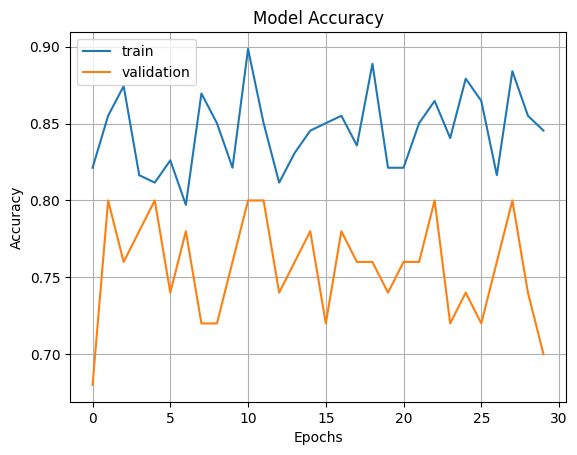

In [17]:
# Plot training accuracy vs validation_accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.grid(True)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

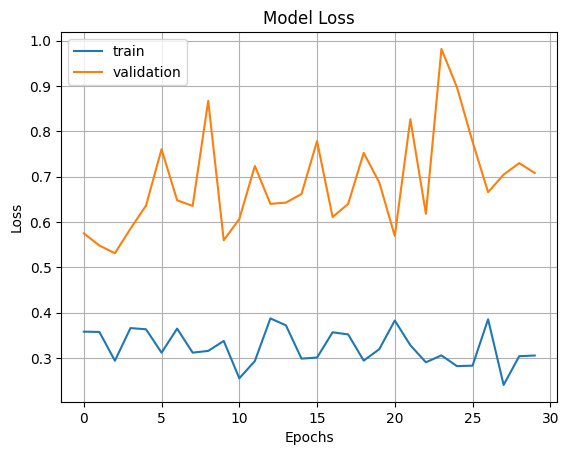

In [18]:
# Plot training loss vs validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid(True)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

No Skill: ROC AUC=0.500
Resnet Model: ROC AUC=0.770


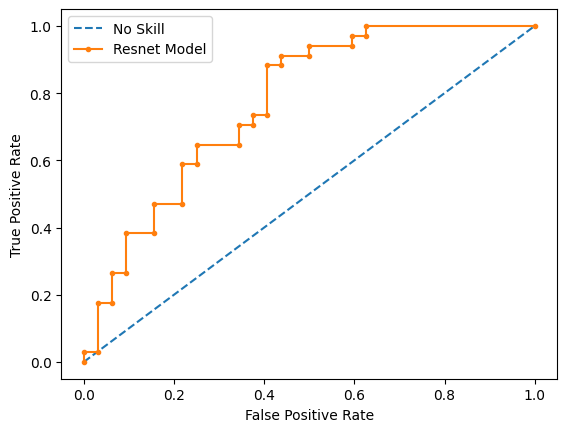

In [20]:
'''
ROC AUC is ultimately a measure of the separation between classes in a binary classifier.
The intent of the ROC Curve is to show how well the model works for every possible threshold, 
as a relation of TPR vs FPR
the blue line represents where TPR = FPR
'''
# calculate scores
ns_probs = [0 for _ in range(len(test_set.classes))]
ns_auc = roc_auc_score(test_set.classes, ns_probs)
lr_auc = roc_auc_score(test_set.classes, predict)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Resnet Model: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(test_set.classes, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(test_set.classes, predict)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Resnet Model')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [21]:

# convert the ouput probablities into binary classes
predict[predict>=0.5] = 1
predict[predict<0.5] = 0

In [27]:
# Model Accuracy
test_accuracy = accuracy_score(test_set.classes, predict)

0.6666666666666666

In [22]:
# Confusion Matrix
c_m = confusion_matrix(test_set.classes, predict)
print(c_m)

[[21 11]
 [11 23]]


In [23]:
# List of labels
list(test_set.class_indices.keys())

['abnormal', 'normal']

In [24]:
# Implementing visualization of Confusion Matrix
display_c_m = ConfusionMatrixDisplay(c_m, display_labels=list(test_set.class_indices.keys()))

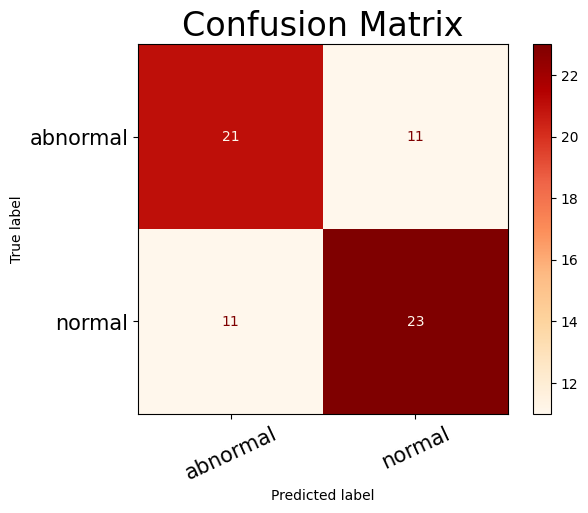

In [25]:
# Plotting Confusion Matrix
# Setting colour map to be used
display_c_m.plot(cmap='OrRd', xticks_rotation=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


# Giving name to the plot
plt.title('Confusion Matrix', fontsize=24)
plt.show()